In [ ]:
from loss import *
from dataset import *
from utils import *
from model import *
from model_resnetyolo import *
from viz import *
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

C=20
B=2
S=13
batch_size=32

# net = Yolov1(split_size=7, num_boxes=2, num_classes=20).cuda()
net = YOLOv1ResNet(S=S, B=B, C=C).cuda()


transform = A.Compose([
    A.Resize(448, 448),
    A.Normalize(),
    ToTensorV2()
], bbox_params=A.BboxParams(format='albumentations')) # format=albumentations is normalized pascal_voc.
dataset=VOCDataset(root='data', image_set='test', S=S,C=C,transform=transform)
dataloader=DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)



net.load_state_dict(torch.load('backup/test3/checkpoint_117.npy'))
# net.load_state_dict(torch.load('models/checkpoint_117.npy'))

net.eval()
with torch.no_grad():
    for i, (img, (boxes, labels, Iobj), train_index) in enumerate(dataloader):
        img, boxes, labels, Iobj = img.cuda(), boxes.cuda(), labels.cuda(), Iobj.cuda()
        out = net(img)
        if i==0:
            break
print('done')
#####################################################

In [ ]:
prob_threshold=0.4
iou_threshold=0.3

predictions = out.reshape(-1, S*S, C + 5 * B)  # (N, S*S, C+5B)
boxes = predictions[..., 20:].reshape(-1, S*S, B, 5)  # (N, S*S, B, 5)
indices=torch.arange(S*S).cuda()

# detect boxes
N_box_det=(boxes[...,0]>prob_threshold) & ((boxes>0).all(-1)) & ((boxes[...,1:3]<1).all(-1)) #N,S*S,B
N_Iobj=N_box_det.any(-1) #N,S*S
#####################################################
i=0

class_probs=predictions[i,:, :20] #S*S,20
box=boxes[i] #S*S,B,5

box_det=N_box_det[i] #S*S,B
Iobj=N_Iobj[i] #S*S
box_det=box_det[Iobj] #I,B
I=box_det.shape[0]



box=box[Iobj]
box_indices=indices[Iobj]
class_probs=class_probs[Iobj] #I,20
label=class_probs.argmax(-1) #I
label_probs=class_probs[torch.arange(I),label]#I
classes=torch.unique(label) # unique classess
all_bbnd=[]
for c in classes:
    Iobj_filtered=label==c
    bbnd=box[Iobj_filtered]
    indx=box_indices[Iobj_filtered]
    ii,jj=indx//S, indx%S
    bbnd[:,:,1]+=jj[:,None]
    bbnd[:,:,2]+=ii[:,None]
    bbnd[...,0]*=label_probs[Iobj_filtered][:,None]
    bbnd=bbnd[box_det[Iobj_filtered]]
    ind_after_nms=non_max_suppression(bboxes=bbnd, iou_threshold=iou_threshold,S=S)
    all_bbnd.append((c.item(),bbnd[ind_after_nms]))

visualize(train_index[i].item(), dataset, all_bbnd,S,plot_truth=False)

3.323138368184435


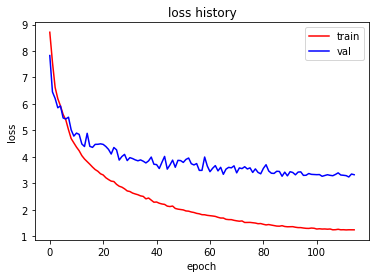

In [4]:
import torch
import matplotlib.pyplot as plt
loss_history = torch.load('logs/loss_history.npy')
print(loss_history['val'][-1])
plt.plot(loss_history['train'], 'r', label='train')
plt.plot(loss_history['val'], 'b', label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss history')
plt.legend()
# plt.ylim([4,5])
plt.show()